In [32]:
import numpy as np
from pydicom import dcmread
from pydicom import multival
import os
import matplotlib.pyplot as plt
from scipy import ndimage
import SimpleITK as sitk
from einops import rearrange
from skimage.transform import resize

In [16]:
DATA_DIR = "/Users/sudarshan/darshanz/datasets/lung1/CT_ONLY/slices"

In [17]:
subject_dir = f"{DATA_DIR}/LUNG1-001"

In [18]:
axial_imgs = []
dcm_paths = []
for dcm_file in os.listdir(f'{subject_dir}/'):
    axial_imgs.append(dcmread(f"{subject_dir}/{dcm_file}").pixel_array)
    dcm_paths.append(f"{subject_dir}/{dcm_file}")

In [19]:
selected_ = dcm_paths[50:60] # for vizualization

In [20]:
ct_volume = np.array(axial_imgs)

In [21]:
print(len(ct_volume))

134


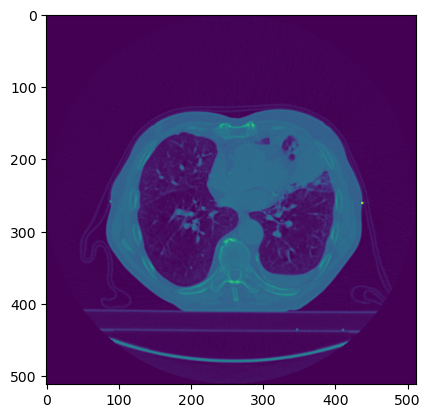

In [22]:
plt.imshow(ct_volume[60])

# Windowing

In [33]:
# Function to take care of teh translation and windowing. 
def window_image(img, window_center,window_width, intercept, slope, rescale=True):
    img = (img*slope +intercept) #for translation adjustments given in the dicom file. 
    img_min = window_center - window_width//2 #minimum HU level
    img_max = window_center + window_width//2 #maximum HU level
    img[img<img_min] = img_min #set img_min for all HU levels less than minimum HU level
    img[img>img_max] = img_max #set img_max for all HU levels higher than maximum HU level
    if rescale: 
        img = (img - img_min) / (img_max - img_min)*255.0
        
    img_resized = resize(img, (224, 224))
    return img_resized
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]


In [34]:
def view_images(files, title = '', aug = None, windowing = True):
    width = 2
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,15))
    
    for im in range(0, height * width):
        data = dcmread(files[im])
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        if windowing:
            output = window_image(image, window_center, window_width, intercept, slope, rescale = False)
        else:
            output = image
        i = im // width
        j = im % width
        axs[i,j].imshow(output, cmap=plt.cm.gray) 
        axs[i,j].axis('off')
        
    plt.suptitle(title)
    plt.show()

In [27]:
#view_images(selected_)

In [30]:
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 9.8 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 18.3 MB/s eta 0:00:00


In [35]:
ct_volume.shape

(134, 512, 512)

In [36]:
ls_vol = []
for dcm_file in os.listdir(f'{subject_dir}/'):
    data  = dcmread(f"{subject_dir}/{dcm_file}")
    window_center , window_width, intercept, slope = get_windowing(data)
    output = window_image(data.pixel_array, window_center, window_width, intercept, slope, rescale = False)
    ls_vol.append(output)

In [37]:
cv_volume = np.array(ls_vol)

In [38]:
cv_volume.shape

(134, 224, 224)

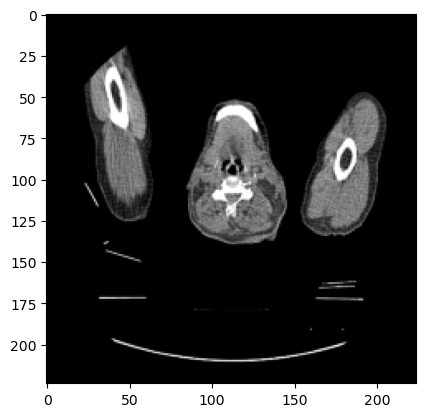

In [39]:
plt.imshow(cv_volume[10], cmap=plt.cm.gray)

In [19]:
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer
scaler = Normalizer()
scaler.fit(cv_volume[10])

Normalizer()

In [20]:
scaled  = scaler.transform(cv_volume[10])

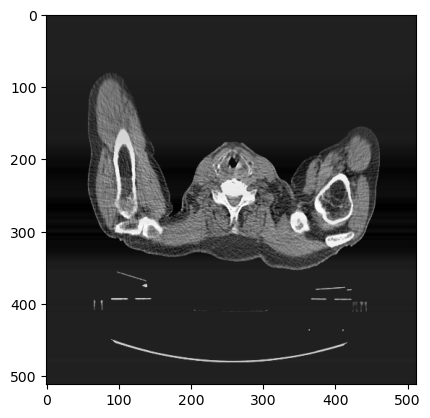

In [21]:
plt.imshow(scaled, cmap=plt.cm.gray)

In [22]:
seg_dir = f"{DATA_DIR}/LUNG1-001/09-18-2008-StudyID-NA-69331/300.000000-Segmentation-9.554/"


In [23]:
seg_dcm_file  = dcmread(f"{seg_dir}/1-1.dcm")
seg_dcm_file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.2323910823.20524.1597260509.555
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Segmentation Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.2323910823.20524.159726050

In [24]:
seg_img = seg_dcm_file.pixel_array

In [25]:
seg_img.shape

(536, 512, 512)

In [26]:
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt

In [27]:

def plot_func(slice_num, img_):
    plt.imshow(img_[slice_num], plt.cm.gray)

interact(plot_func, slice_num = widgets.IntSlider(value=1, min=0,  max=133, step=1), img_=widgets.fixed(cv_volume))

interactive(children=(IntSlider(value=1, description='slice_num', max=133), Output()), _dom_classes=('widget-i…

<function __main__.plot_func(slice_num, img_)>

In [28]:

def plot_func(slice_num, img_):
    plt.imshow(img_[slice_num], plt.cm.gray)

interact(plot_func, slice_num = widgets.IntSlider(value=1, min=0,  max=133, step=1), img_=widgets.fixed(seg_img))

interactive(children=(IntSlider(value=1, description='slice_num', max=133), Output()), _dom_classes=('widget-i…

<function __main__.plot_func(slice_num, img_)>

In [29]:
seg_img.shape

(536, 512, 512)

### Steps
- saving the dicom slices to the subject folders : removing the nested folders : ignoring the segmentation files.
- Segmentation information is not used in this study

In [1]:
for subject_ in sorted(os.listdir(DATA_DIR)):
    if '.' not in subject_[0] and 'LICENSE' not in subject_:
        for files_ in os.listdir(f"{DATA_DIR}/{subject_}"):
            if '.' not in files_[0] and "StudyID" in files_:
                selected_folder = "" 
                max_files = -1 # to choose the folder with maximum number of files. 
                for files__ in os.listdir(f"{DATA_DIR}/{subject_}/{files_}/"):
                    folder_name = f"{DATA_DIR}/{subject_}/{files_}/{files__}"
                    file_count =  0 if '.' in files__[0] else len(os.listdir(folder_name))                  
                    if file_count >= max_files:
                        selected_folder =  f"{DATA_DIR}/{subject_}/{files_}/{files__}/"
                        max_files = file_count                         
        print(">>>>>>>>"+subject_,  selected_folder , max_files)
        dest_folder = f"{CT_Slice_DIR}/{subject_}"
         
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)
            
        for slice__ in tqdm(os.listdir(selected_folder)):
            shutil.copy(selected_folder+"/"+slice__, dest_folder)

NameError: name 'os' is not defined